# Unet for multi-class segmentation
Train and predict

## Chalange description

The data is 3D MRI images with 4 channels:
* Flair
* T1
* T1ce
* T2

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema 
* Label 4: enhancing tumor

In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:
> (155, 240, 240, 4)
> For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

In [311]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [312]:
DATA = 'C:/Users/student/Desktop/Naomi_dataset/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = 'C:/Users/student/Desktop/Naomi_dataset/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'/HGG/'
DATA_LGG = DATA +'/LGG/'
NUMPY_DIR = 'C:/Users/student/Desktop/Naomi_dataset/train_numpy_images/'
VALIDATION_NUMPY_DIR  = 'C:/Users/student/Desktop/Naomi_dataset/val_numpy_images/'

'''
DATA= 'dicom/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = 'dicom/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'/HGG/'
DATA_LGG = DATA +'/LGG/'

NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Training/numpy_images/'
VALIDATION_NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Validation/numpy_images/'
'''
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [313]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [314]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [315]:
import pandas
import numpy

In [316]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random
from random import randrange
from keras.utils import np_utils

## Visualization utilities

In [317]:
from importlib import reload  # Python 3.4+ only.
import visualization_utils  as vu
from visualization_utils import show_lable_on_image4
reload(vu)

<module 'visualization_utils' from 'C:\\Users\\student\\Desktop\\BTS\\visualization_utils.py'>

In [318]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.] #[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [322]:
def show_pred_im(im, pred):
    
    vu.show_n_images([im[:,:,1], 
                   im[:,:,0],pred,
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair','T1', 'Pred',  'Prediction on Flair'])

## Read image description files
In the preprocessing notebook, all files where saved as numpy.

Some statistics on the labels were collected, to assist the training phase.

In [323]:
df_train= pd.read_csv('df_train.csv')
df_test= pd.read_csv('df_test.csv')
df_val= pd.read_csv('df_val.csv')

## Build Train generator

In [324]:
def get_numpy_img_lbl(img_id = 'BraTS19_TCIA10_449_1', np_dir=NUMPY_DIR):
    img=np.load(os.path.join(np_dir, img_id+'.npy'))
    lbl=np.load(os.path.join(np_dir, img_id+'_lbl.npy'))
    return img,lbl

Function randomly selects a 2D image that includes the given label

In [326]:
def get_img_for_label(lab=2, axis=0, df=df_train,np_dir = NUMPY_DIR):
    
    img_id= random.choice(df[df['lab'+str(lab)] > 0].id.values)
    
    img,lbl = get_numpy_img_lbl(img_id, np_dir)
    ind = np.where(lbl==lab)
    k = random.randrange(len(ind[0]))
    
    if (axis==0):        
        return img[ind[0][k],:,:] , lbl[ind[0][k],:,:]
        
    lb = np.zeros((240,240),dtype=np.int)
    im = np.zeros((240,240,4),dtype=np.float32)
    
    if (axis==1):
        im[40:40+155,:,:]=img[:, ind[1][k],:,:]
        lb[40:40+155,:]=lbl[:, ind[1][k],:]
        return im,lb
    
    if (axis == 2):
        im[40:40+155,:,:]=img[:, :, ind[2][k],:]
        lb[40:40+155,:]=lbl[:,:,ind[2][k]]
        return im,lb
    return None

In [327]:
def lbl_from_cat(cat_lbl):
    
    lbl=0
    if (len(cat_lbl.shape)==3):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,i]*i
    elif (len(cat_lbl.shape)==4):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,:,i]*i
    else:
        print('Error in lbl_from_cat', cat_lbl.shape)
        return None
    return lbl

For test we will create batch from few test images. only planes with lables >0 will be included.

In [328]:
def normalize_3D_image(img):
    for z in range(img.shape[0]):
        for k in range(4):
            if (img[z,:,:,k].max()>0):
                img[z,:,:,k] /= img[z,:,:,k].max()
    return img

Function returns all z-planes of the image that have non-zerolable

Get images with non-zero labels from all raws of given data frame

Generator for test images

Test the generator,takes
```
CPU times: user 640 ms, sys: 1.3 s, total: 1.94 s
Wall time: 2.72 s
```
3 images, ~251 planes

Test the faster generator. Takes:
```
CPU times: user 1.58 s, sys: 6.29 s, total: 7.87 s
Wall time: 12.4 s
```
for 32 batch size

Slower train batch, but more ballanced in labels,

Define train generator and test that it works correctly.
> Takes: 
CPU times: 
user 2.52 s, sys: 12 s, total: 14.5 s
Wall time: 29.2 s
> for batch size 32 

## define Base Unet Model

In [335]:
import tensorflow as tf
from keras import backend as K

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Input, UpSampling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [336]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_CHANNELS = 4

In [337]:
import model_unet
reload(model_unet)

<module 'model_unet' from 'C:\\Users\\student\\Desktop\\BTS\\model_unet.py'>

In [338]:

#model = model_unet.unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
model = model_unet.unet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [339]:
#model.save_weights('model_unet_4ch.hdf5')   #model_unet_ce.hdf5

In [340]:
model.load_weights('model_unet_4ch.hdf5')

## Predict with trained model

Function converts probabilities to labels

In [341]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

In [342]:
def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

In [343]:
def predict_3D_img_prob(np_file):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((155, 240, 240, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img

## Predict on Test images

View predicted probabilities, and the resulted labels

## Predict all test images to calculate IOU

In [345]:
TEST_PRED_NUMPY_DIR = 'C:/Users/student/Desktop/Naomi_dataset/predictions/pred1/test/numpy_images/'
VALIDATION_PRED_NUMPY_DIR = 'C:/Users/student/Desktop/Naomi_dataset/predictions/pred1/validation/numpy_images/'
VALIDATION_PRED_NII_DIR = 'C:/Users/student/Desktop/Naomi_dataset/predictions/pred1/validation/nii/'

Check that its all working -:)

## Predict all validation image

In [346]:
#df_val.head()

<Figure size 432x360 with 0 Axes>

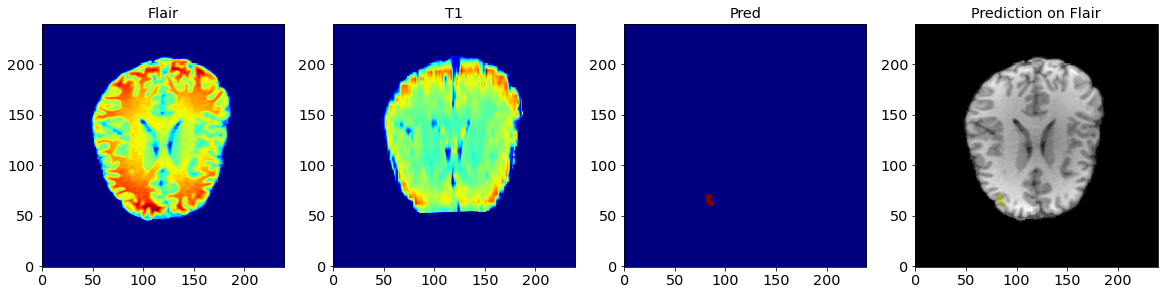

In [347]:
img_id='BraTS19_2013_1_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[88], pred[88])